In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

Vectorization for Speed

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [3]:
# Using for-loop in python
c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
f'{time.time() - t:.5f} sec'

'0.32452 sec'

In [4]:
# Using reloaded + operator to compute the elementwise sum
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00000 sec'

In [5]:
# define a function to compute the normal distribution
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

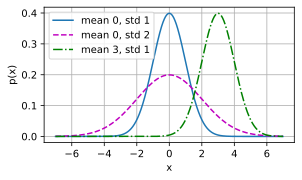

In [6]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)
# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
        ylabel='p(x)', figsize=(4.5, 2.5),
        legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

### Object-Oriented Design for Implementation

In [4]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

Utilities

In [5]:
def add_to_class(Class): #@save
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [6]:
class A:
    def __init__(self):
        self.b = 1
a = A()

In [7]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)
a.do()

Class attribute "b" is 1


In [8]:
class HyperParameters: #@save
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

In [9]:
# Call the fully implemented HyperParameters class saved in d2l
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))
b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


In [10]:
class ProgressBoard(d2l.HyperParameters): #@save
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()
    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

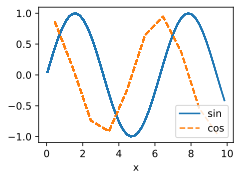

In [11]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

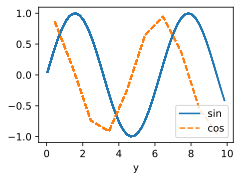

In [12]:
board = d2l.ProgressBoard('y')
for y in np.arange(0, 10, 0.1):
    board.draw(y, np.sin(y), 'sin', every_n=2)
    board.draw(y, np.cos(y), 'cos', every_n=10)

Models

In [13]:
class Module(nn.Module, d2l.HyperParameters): #@save
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
    def loss(self, y_hat, y):
        raise NotImplementedError
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)
    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
            self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                            ('train_' if train else 'val_') + key,
                            every_n=int(n))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)
    def configure_optimizers(self):
        raise NotImplementedError

Data

In [15]:
class DataModule(d2l.HyperParameters): #@save
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()
        
    def get_dataloader(self, train):
        raise NotImplementedError
        
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    
    def val_dataloader(self):
        return self.get_dataloader(train=False)

Training

In [18]:
class Trainer(d2l.HyperParameters): #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'
        
    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
        
    def fit_epoch(self):
        raise NotImplementedError

### Synthetic Regression Data

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

Generating the Dataset

In [4]:
class SyntheticRegressionData(d2l.DataModule): #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

In [5]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

In [6]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([ 0.8317, -2.3650]) 
label: tensor([13.9030])


In [7]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

In [8]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


#### Concise Implementation of the Data Loader

Generate and Read Dataset through an Existing API

In [10]:
@d2l.add_to_class(d2l.DataModule) #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                        shuffle=train)

In [12]:
@d2l.add_to_class(SyntheticRegressionData) #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [13]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
